In [1]:
Sys.setenv(RETICULATE_PYTHON = "/home/gonglihao/miniconda3/envs/42/bin/python")
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("SeuratWrappers")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("DoubletFinder")
})

source("/data3/Group8/gonglihao/1-MMP9/1-QC/doublet_removal.R")

In [2]:
path <- "/data3/Group8/gonglihao/MMP9/matrix/shNC.matrix" 
proj.name <-"shNC"

In [3]:
tic()
CreateSeuratObject(counts= Read10X(data.dir= path), project = proj.name, min.cells = 0, min.features = 0) %>%
#RenameCells(add.cell.id = proj.name) %>%
PercentageFeatureSet(pattern = "^mt-", col.name = "percent.mt") -> seu
toc()


options(warn=-1)
tic()
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
plan("sequential")
seu <- ScaleData(seu,  features=rownames(seu), block.size = 1000, min.cells.to.block = 1000)
plan("sequential")
toc()

tic()
seu <- RunPCA(seu, npcs=30, verbose = FALSE)
seu <- RunUMAP(seu, dims = 1:30, umap.method = "umap-learn", metric = "correlation", verbose = FALSE)
toc()

tic()
seu <- FindNeighbors(object = seu, dims = 1:30,verbose=FALSE)
seu <- FindClusters( object = seu, resolution = c(0.1,0.2,0.3,0.4,0.5),verbose=FALSE)
toc()

14.654 sec elapsed


Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



23.572 sec elapsed
125.684 sec elapsed
8.612 sec elapsed


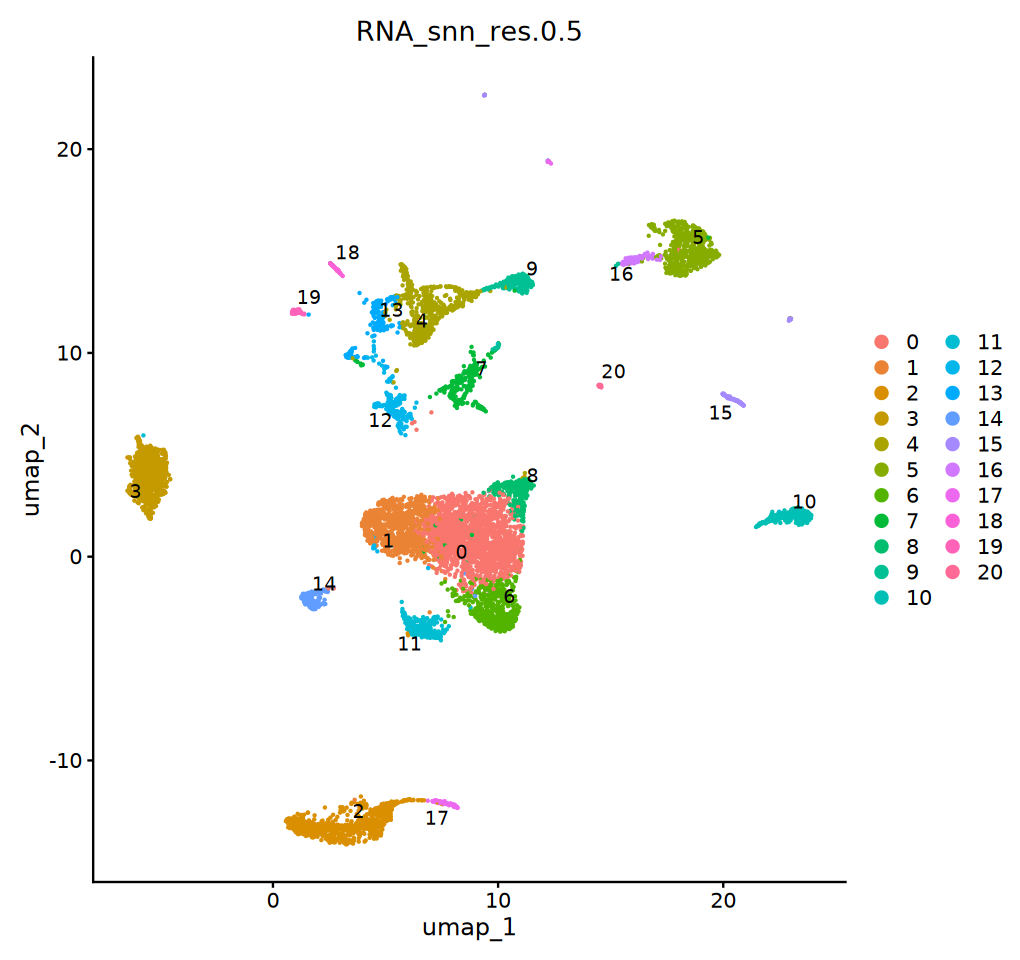

In [4]:
options(repr.plot.width=8.5, repr.plot.height=8)
UMAPPlot(seu, group.by="RNA_snn_res.0.5", label=T,repel=T)

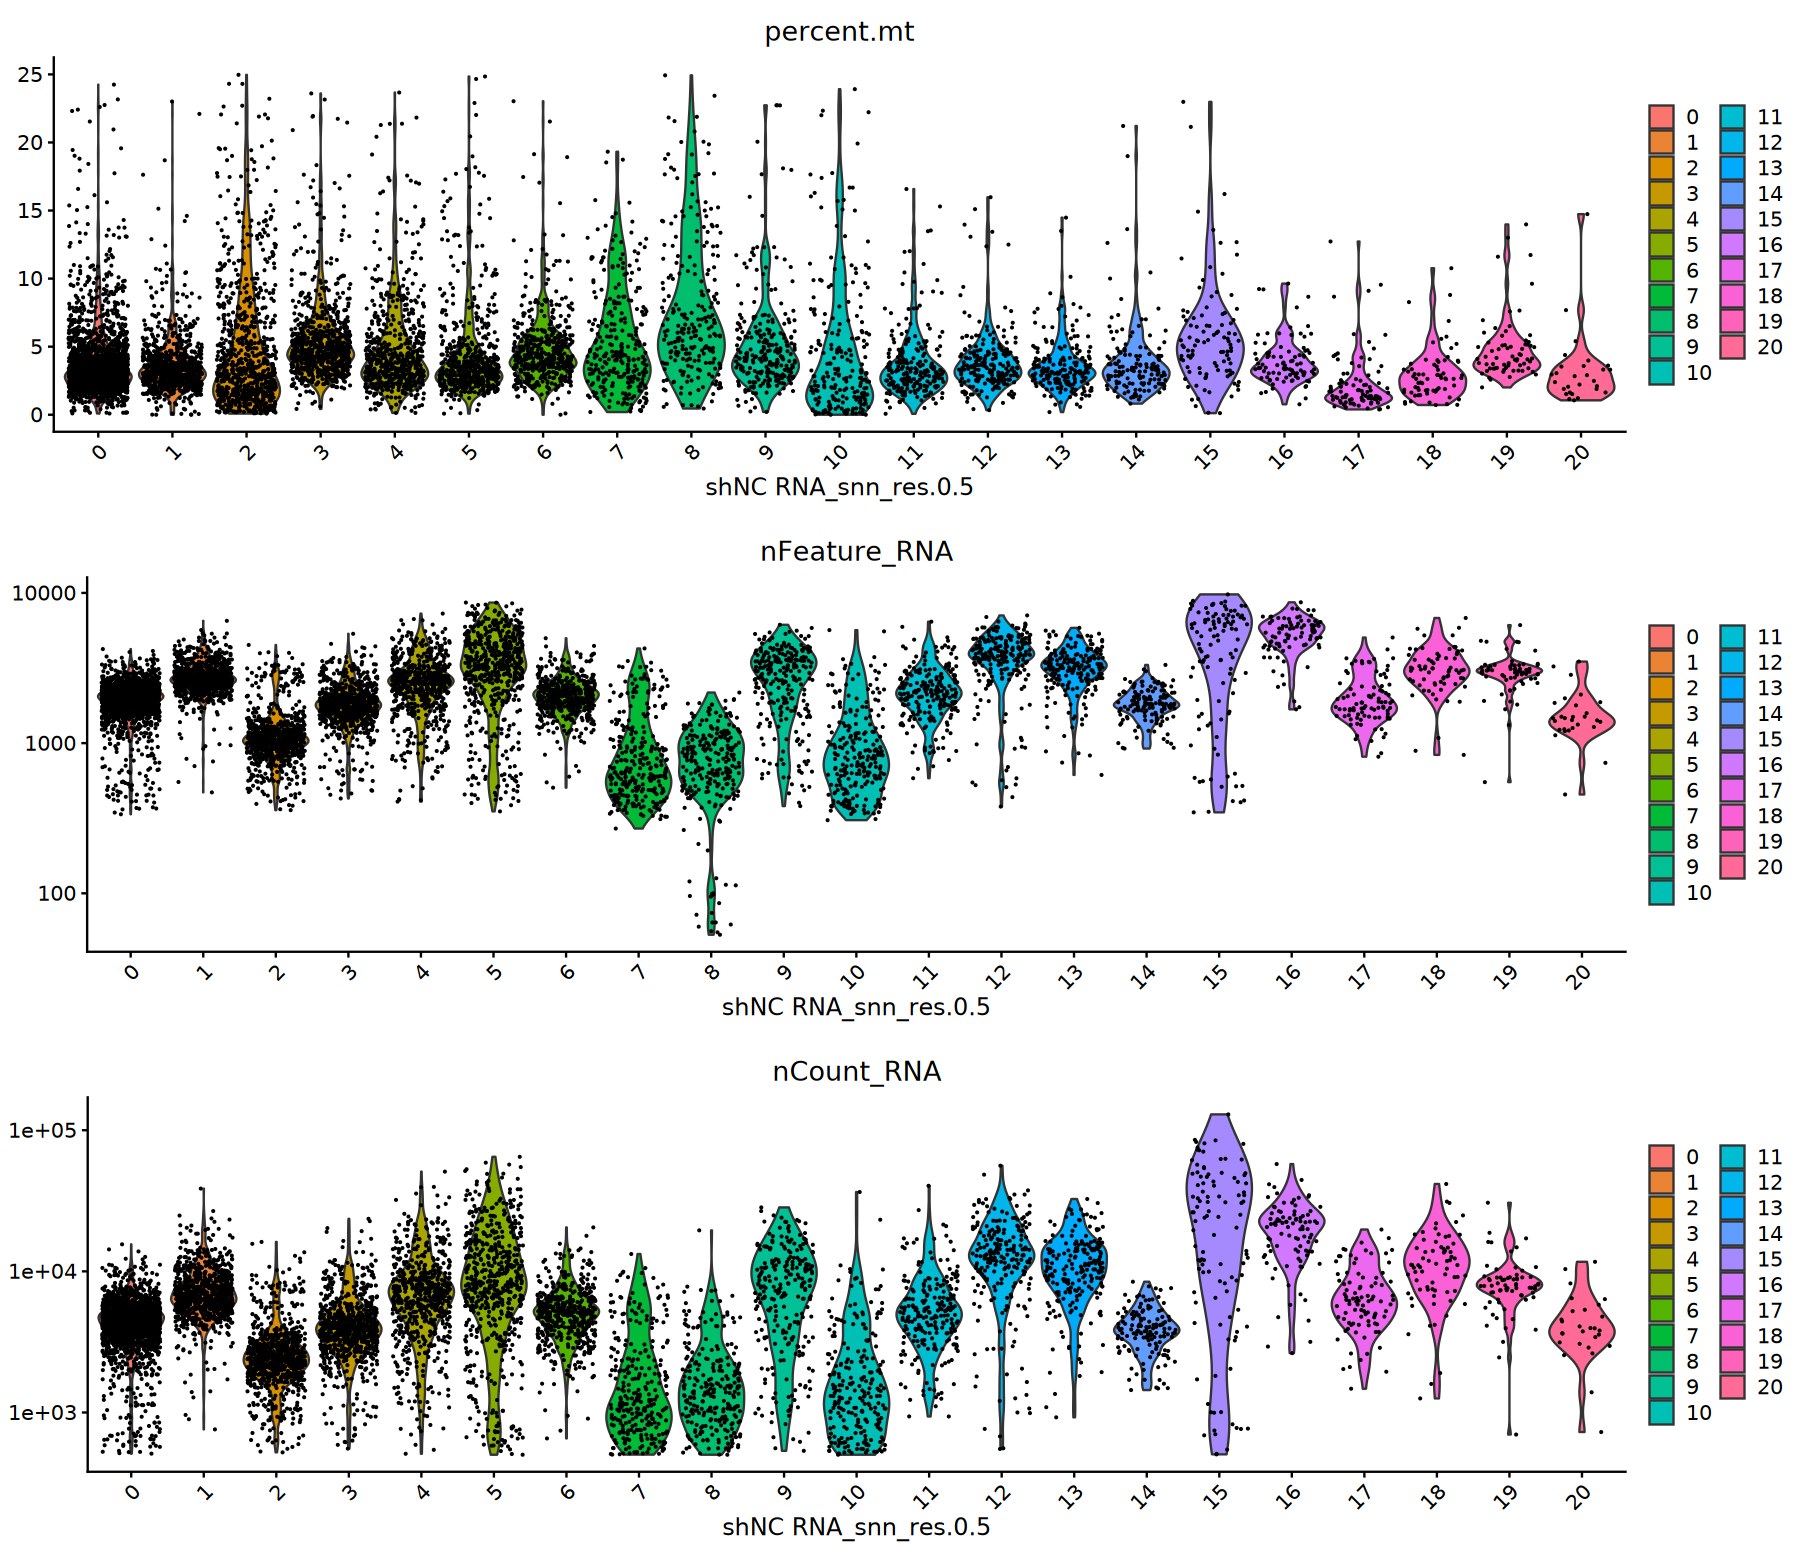

In [5]:
options(repr.plot.width=15, repr.plot.height=13)
Idents(seu)<-"RNA_snn_res.0.5"
group.by<-'RNA_snn_res.0.5'
ggarrange(ncol=1, nrow=3,
VlnPlot(seu, features = "percent.mt", pt.size=0.1,y.max=25, log=F, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nFeature_RNA", pt.size=0.1, log=T, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nCount_RNA", pt.size=0.1, y.max=10000,log=T, group.by=group.by)+xlab(paste(proj.name,group.by))
)

In [6]:
seu<-subset(seu, subset=percent.mt<10 & nFeature_RNA>500)

In [7]:
options(warn=-1)
tic()
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)
plan("sequential")
seu <- ScaleData(seu,  features=rownames(seu), block.size = 1000, min.cells.to.block = 1000)
plan("sequential")
toc()

tic()
seu <- RunPCA(seu, npcs=30, verbose = FALSE)
seu <- RunUMAP(seu, dims = 1:30, umap.method = "umap-learn", metric = "correlation", verbose = FALSE)
toc()

tic()
seu <- FindNeighbors(object = seu, dims = 1:30,verbose=FALSE)
seu <- FindClusters( object = seu, resolution = c(0.1,0.2,0.3,0.4,0.5),verbose=FALSE)
toc()

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



25.983 sec elapsed
79.947 sec elapsed
7.765 sec elapsed


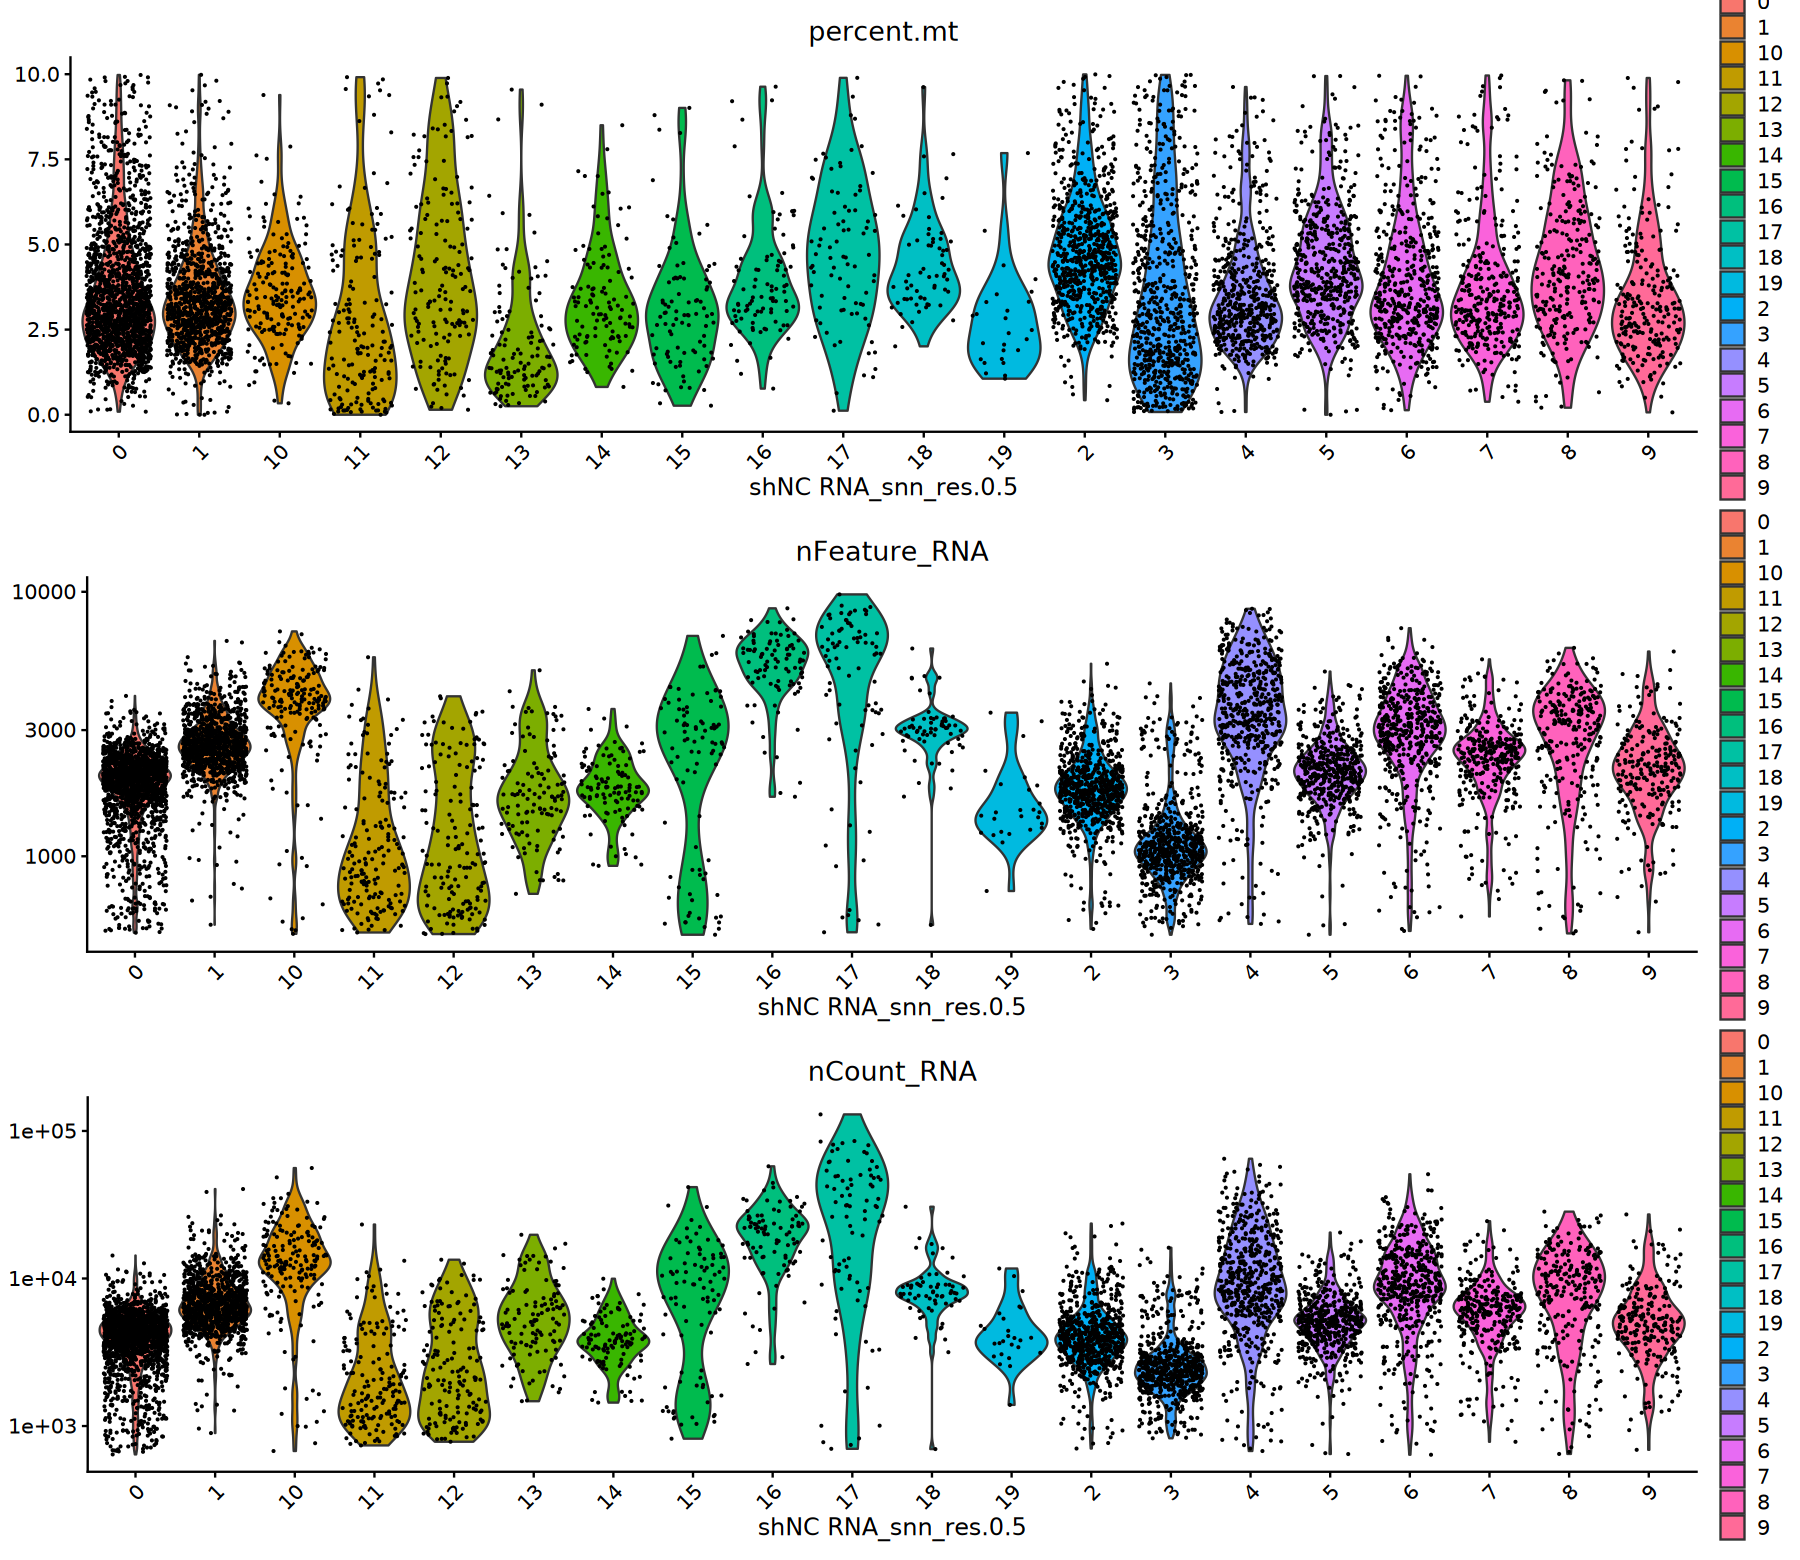

In [8]:
options(repr.plot.width=15, repr.plot.height=13)
Idents(seu)<-"RNA_snn_res.0.5"
group.by<-'RNA_snn_res.0.5'
ggarrange(ncol=1, nrow=3,
VlnPlot(seu, features = "percent.mt", pt.size=0.1, log=F, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nFeature_RNA", pt.size=0.1, log=T, group.by=group.by)+xlab(paste(proj.name,group.by)),
VlnPlot(seu, features = "nCount_RNA", pt.size=0.1, y.max=10000,log=T, group.by=group.by)+xlab(paste(proj.name,group.by))
)

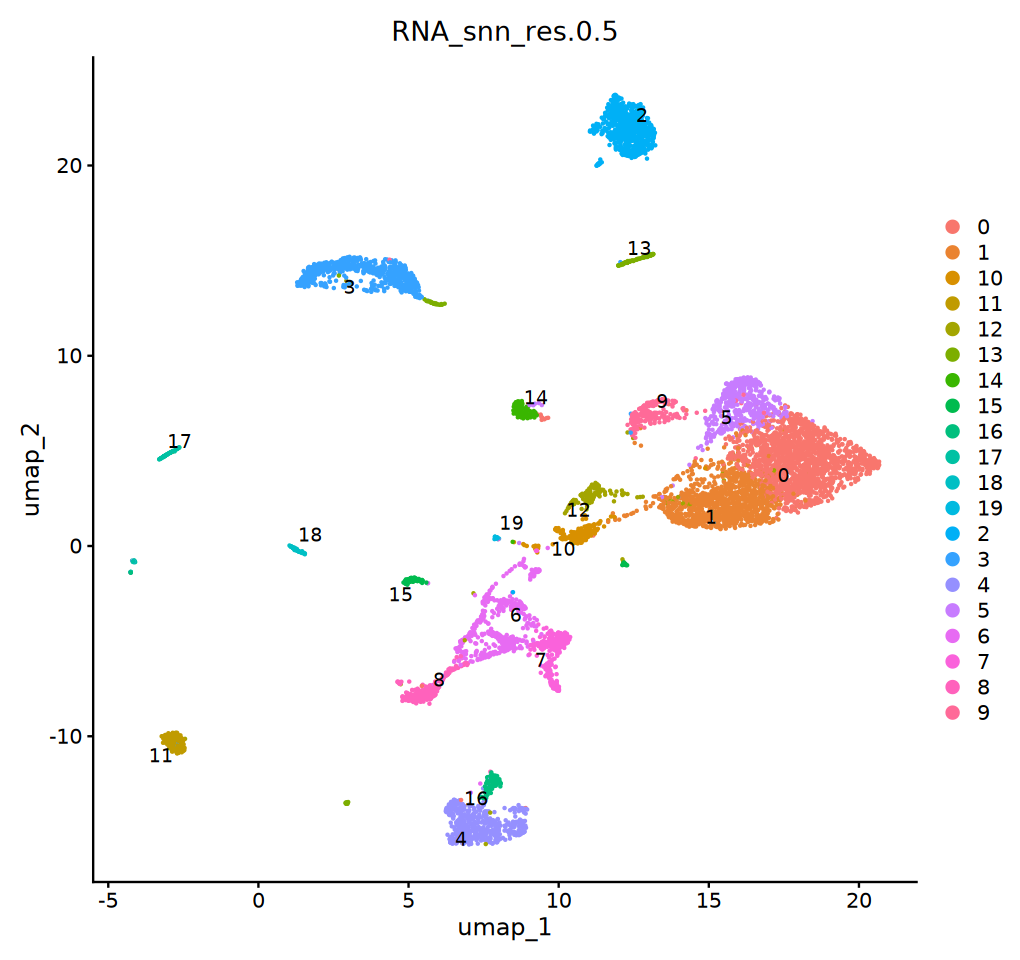

In [9]:
options(repr.plot.width=8.5, repr.plot.height=8)
UMAPPlot(seu, group.by="RNA_snn_res.0.5", label=T,repel=T)

In [10]:
options(warn =-1)
tic()
params<-DoubletRemovalParameters(seu, PCs=1:30)
toc()
options(warn =0)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



sweep parameters: 551.086 sec elapsed
551.109 sec elapsed


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


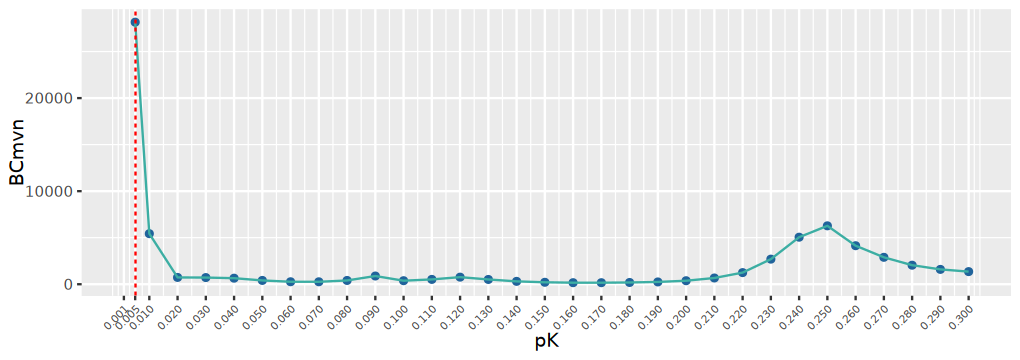

In [11]:
options(repr.plot.wdith=8, repr.plot.height=3)
bcmvnPlot(params$bcmvn, maxpos =0.005)

In [12]:
doublet.rate   <- 0.06
annotations    <- seu@meta.data$RNA_snn_res.0.5
homotypic.prop <- modelHomotypic(annotations) 
nExp_poi       <- round(doublet.rate*length(colnames(x = seu)))  ## Assuming 7.5% doublet formation rate - tailor for your dataset
nExp_poi.adj   <- round(nExp_poi*(1-homotypic.prop))
nExp_poi.adj

[1] 408

In [13]:
pK <- 0.005

tic()
seu.scored     <- doubletFinder(seu, PCs =1:30, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
toc()

# Run it only once!!! or may cause problem
cname     <- colnames(seu.scored[[]])
DF.name   <- cname[grep('^DF',cname)] 
pANN.name <- cname[grep('^pANN',cname)] 
seu.scored[["doublet"]]<-seu.scored[[DF.name]]
seu.scored[["pANN"]]   <-seu.scored[[pANN.name]]
seu.scored[[DF.name]]  <-NULL
seu.scored[[pANN.name]]<-NULL

[1] "Creating 2544 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."


Normalizing layer: counts



[1] "Finding variable genes..."


Finding variable features for layer counts



[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
90.213 sec elapsed


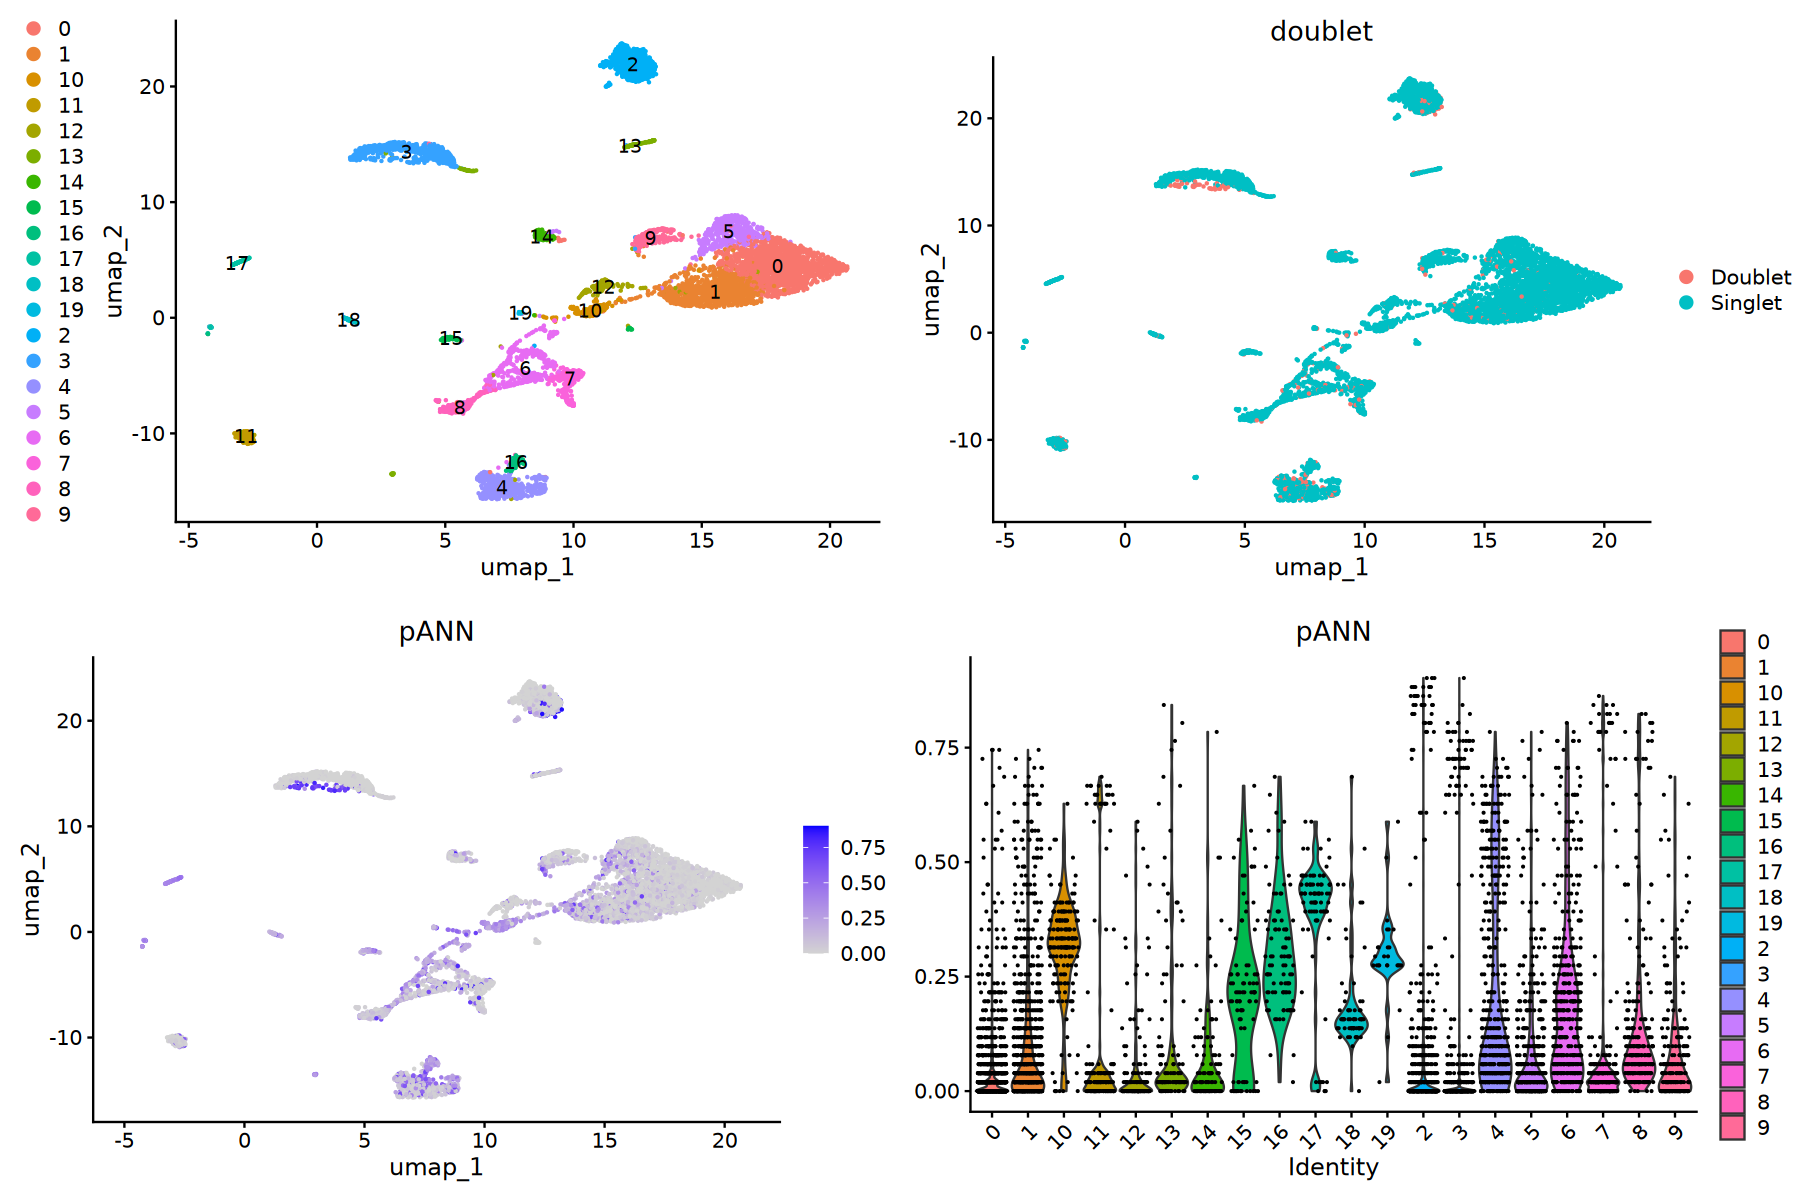

In [14]:
options(repr.plot.width=15,repr.plot.height=10)
p1<-DimPlot(seu.scored, reduction = "umap",label=T)+theme(legend.position="left")
p2<-DimPlot(seu.scored, reduction = "umap",group.by="doublet")+theme(legend.position="right")
p3<-FeaturePlot(seu.scored, features = "pANN")
p4<-VlnPlot(seu.scored, features = "pANN", group.by = "RNA_snn_res.0.5",pt.size=0.1)

library(ggpubr)
ggarrange(p1,p2,p3,p4,nrow=2,ncol=2)

In [15]:
seu.scored->seu

In [16]:
tic()
save(seu, file="/data3/Group8/gonglihao/1-MMP9/1-QC/shNC.rda", compress=T)
toc()

109.395 sec elapsed
